# Introdução

Regression Discontinuity Design (RDD) é uma técnica de identificação causal que explora descontinuidades arbitrárias em regras de atribuição para estimar efeitos causais. A ideia central é que, próximo ao ponto de corte, a atribuição do tratamento é "quase aleatória".

O RDD pode ser aplicado quando existe uma regra clara que determina quem recebe um tratamento baseado em uma variável contínua (running variable) e um ponto de corte específico. Por exemplo:

 - Bolsas de estudo baseadas em notas acima de determinado valor
 - Programas sociais para pessoas com renda abaixo de certo limite
 - Medicamentos aprovados apenas para pacientes acima de determinada idade

A estratégia de identificação assume que indivíduos muito próximos ao ponto de corte são similares em características observáveis e não-observáveis, diferindo apenas no acesso ao tratamento.

O modelo linear usado na **RDD (Regressão Discontínua)** pode ser escrito da seguinte forma:

$$
Y_i = \beta_0 + \beta_1 \cdot D_i + \beta_2 \cdot (X_i - c) + \varepsilon_i
$$

Onde:

* $Y_i$: variável de desfecho (outcome);
* $D_i$: indicador de tratamento (1 se $X_i \geq c$, 0 caso contrário);
* $X_i$: variável de corte (running variable ou forcing variable);
* $c$: ponto de corte (threshold), geralmente centrado para que $X_i - c = 0$ no limite;
* $\beta_0$: intercepto (valor esperado de $Y$ no limite à esquerda do ponto de corte);
* $\beta_1$: **efeito causal local** do tratamento (diferença no valor esperado de $Y$ no ponto de corte);
* $\beta_2$: inclinação da relação entre $X$ e $Y$ no controle;
* $\varepsilon_i$: erro aleatório.

Nesse modelo linear, as interpretações dos coeficientes são:

* **$\beta_0$**: valor esperado de $Y$ no ponto de corte **para o grupo controle** (ou seja, à esquerda do ponto de corte, onde $D_i = 0$ e $X_i = c$).

* **$\beta_1$**: **efeito causal local do tratamento** — representa a diferença média em $Y$ entre os grupos tratado e controle **exatamente no ponto de corte**.

* **$\beta_2$**: inclinação da relação entre a variável de corte $X$ e o desfecho $Y$ **para o grupo controle**.


Esse modelo assume uma relação linear com a variável de corte e estima o salto na média de $Y$ exatamente no ponto de corte como sendo $\beta_1$.


# Estudo de Caso

Considere que um programa educacional piloto está sendo avaliado com o objetivo de investigar se a **frequência escolar** mínima exerce impacto causal sobre o **desempenho dos estudantes**. Segundo as regras do programa, apenas os estudantes cuja taxa de frequência caiu **abaixo de um certo ponto de corte** são automaticamente inscritos em uma **intervenção pedagógica complementar** (por exemplo, tutoria, mentoria, reforço escolar).

A hipótese a ser avaliada por meio da Regressão Discontínua nesse caso é:

> **Estudantes cuja frequência ficou abaixo do ponto de corte e, por isso, receberam a intervenção pedagógica, apresentaram desempenho significativamente melhor do que teriam apresentado sem o tratamento.**

Justificativa para uso da RDD:

* A decisão de tratar os alunos depende de uma **regra baseada em um limiar da frequência**.
* Estudantes próximos ao ponto de corte são presumivelmente semelhantes em características não observadas.
* Isso permite interpretar a **diferença no desempenho exatamente no corte como efeito causal local do tratamento**.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

data = pd.read_csv("../data/attendance_performance.csv")
data.head()

,Unnamed: 0,Performance,Treatment,Attendance,Attendance_c
0,1,77.702123,0,88.963102,9.703697
1,2,76.427011,0,88.842512,9.583107
2,3,61.506374,1,62.684335,-16.575070
3,4,76.465925,0,83.401473,4.142068
4,5,87.255437,0,94.567788,15.308383


Estrutura dos dados:

* **Desfecho:**
  `Performance` (nota ou medida padronizada de desempenho final).

* **Tratamento:**
  `Treatment` (1 se o aluno recebeu a intervenção pedagógica; 0 caso contrário).
  Atribuído com base na `Attendance`, conforme o ponto de corte.
  
* **Variável de escore (running variable):**
  `Attendance` (frequência escolar, em %).
  Também usamos uma versão centralizada: `Attendance_c = Attendance − cutoff`.

In [2]:
data.shape

(1000, 5)

In [3]:
df_temp = data[['Performance', 'Attendance']].copy()
df_temp

,Performance,Attendance
0,77.702123,88.963102
1,76.427011,88.842512
2,61.506374,62.684335
3,76.465925,83.401473
4,87.255437,94.567788
...,...,...
995,74.207382,89.406917
996,53.260394,61.685627
997,74.140383,90.999837
998,59.254342,71.001560


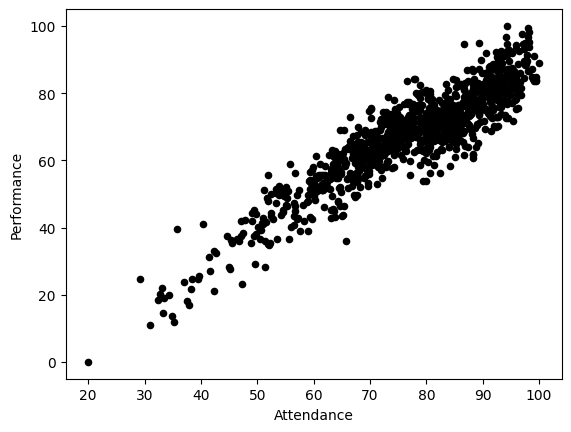

In [4]:
ax1 = df_temp.plot.scatter(x='Attendance', y='Performance', c='Black')

Vamos considerar que o ponto de corte foi definido como a mediana da frequência.

In [5]:
cutoff_point = df_temp['Attendance'].median()
cutoff_point

79.2594048757705

Vamos agora plotar os dados e uma linha vertical correspondente ao ponto de corte.

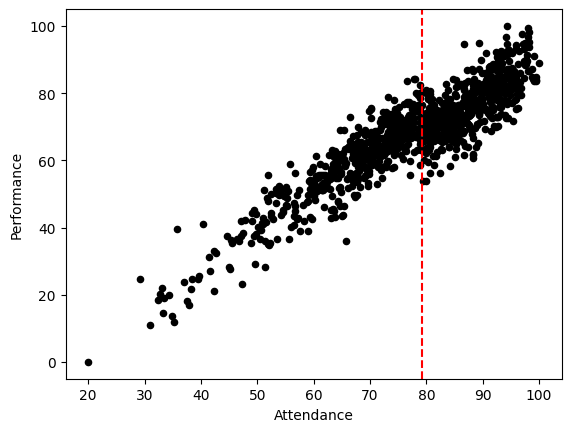

In [6]:
import matplotlib.pyplot as plt

# Assuming df_temp is your DataFrame
ax1 = data.plot.scatter(x='Attendance', y='Performance', c='Black')

# Add a dashed vertical line at Attendance=cutoff_point
ax1.axvline(x=cutoff_point, color='red', linestyle='--')

# Show the plot
plt.show()


A centralização da variável explicativa (neste exemplo, `Attendance_c = Attendance - cutoff`) é essencial em RDD porque **permite que o ponto de corte seja representado como zero**, o que simplifica a modelagem e a interpretação dos coeficientes. Com a variável centralizada, o **efeito causal local** pode ser interpretado diretamente como o salto na interceptação da regressão em `x = 0`, ou seja, exatamente no ponto de corte. Isso torna o modelo mais transparente e o coeficiente do tratamento mais facilmente interpretável como o efeito causal no limite.

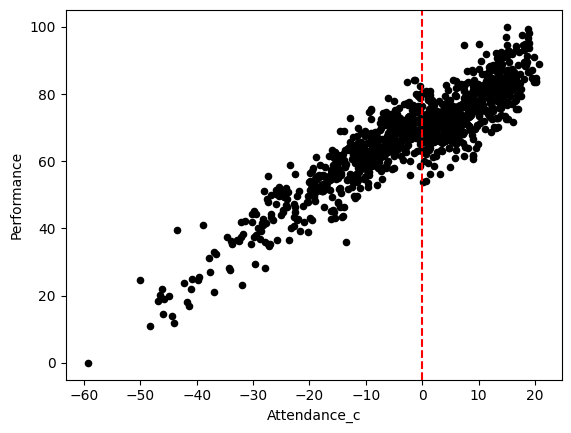

In [7]:
import matplotlib.pyplot as plt

# Assuming df_temp is your DataFrame
ax1 = data.plot.scatter(x='Attendance_c', y='Performance', c='Black')

# Add a dashed vertical line at Attendance=cutoff_point
ax1.axvline(x=0, color='red', linestyle='--')

# Show the plot
plt.show()

O código abaixo implementa a estimativa do **efeito causal local** em um cenário de Regressão Discontínua (RDD) usando regressões separadas à esquerda e à direita do ponto de corte. Dois modelos de regressão linear simples são ajustados, ambos tendo como variável dependente o desempenho (`Performance`) e como variável explicativa a presença centralizada (`Attendance_c`): 
- um para os alunos com `Attendance_c < 0` (lado esquerdo, grupo tratado) 
- outro para os com `Attendance_c ≥ 0` (lado direito, grupo controle). 

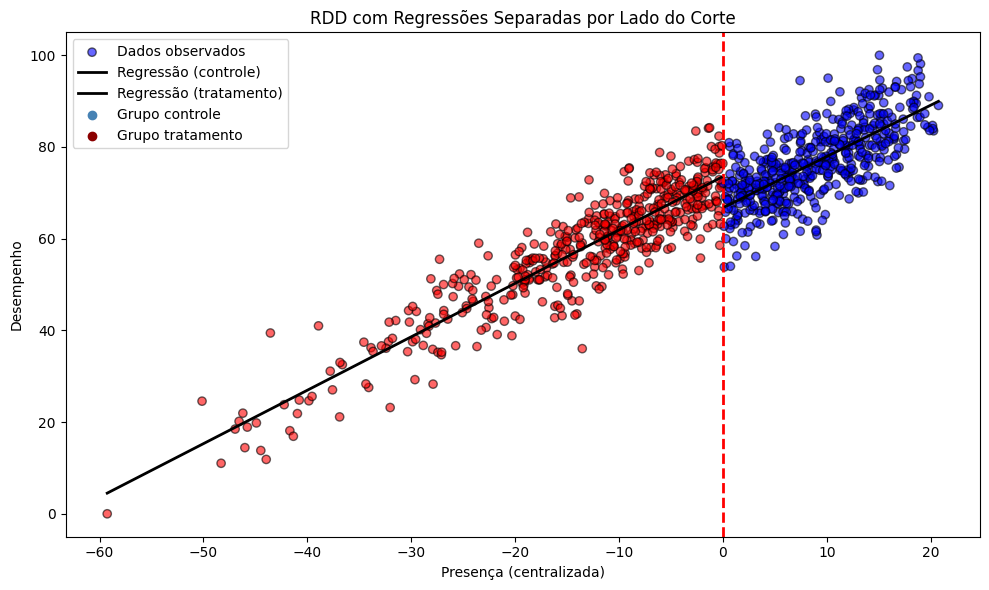

In [8]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

df = data

# Supondo que os dados já estejam carregados no DataFrame `df`
# com as colunas: 'Attendance_c', 'Treatment' e 'Performance'

# Dividir os dados em esquerda e direita do ponto de corte
esquerda = df[df['Attendance_c'] < 0]
direita = df[df['Attendance_c'] >= 0]

# Regressão linear em cada lado
X_esq = sm.add_constant(esquerda['Attendance_c'])
X_dir = sm.add_constant(direita['Attendance_c'])
y_esq = esquerda['Performance']
y_dir = direita['Performance']

modelo_esq = sm.OLS(y_esq, X_esq).fit()
modelo_dir = sm.OLS(y_dir, X_dir).fit()

# Valores para predição
x_vals = np.linspace(df['Attendance_c'].min(), df['Attendance_c'].max(), 200)
x_esq_vals = x_vals[x_vals < 0]
x_dir_vals = x_vals[x_vals >= 0]

y_pred_esq = modelo_esq.predict(sm.add_constant(x_esq_vals))
y_pred_dir = modelo_dir.predict(sm.add_constant(x_dir_vals))

# Plotagem
plt.figure(figsize=(10, 6))

# Pontos observados
plt.scatter(df['Attendance_c'],
            df['Performance'],
            c=df['Treatment'],
            cmap=plt.cm.bwr,
            edgecolors='k',
            alpha=0.6,
            label='Dados observados')

# Linha de corte
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)

# Regressões separadas
plt.plot(x_esq_vals, y_pred_esq, color='black', linewidth=2, label='Regressão (controle)')
plt.plot(x_dir_vals, y_pred_dir, color='black', linewidth=2, label='Regressão (tratamento)')

# Legenda
plt.scatter([], [], c='steelblue', marker='o', label='Grupo controle')
plt.scatter([], [], c='darkred', marker='o', label='Grupo tratamento')
plt.legend()

# Eixos e título
plt.xlabel("Presença (centralizada)")
plt.ylabel("Desempenho")
plt.title("RDD com Regressões Separadas por Lado do Corte")
plt.tight_layout()
plt.show()


# Efeito Causal Local

O **efeito causal local** é a diferença média no desfecho de interesse entre indivíduos tratados e não tratados, **avaliada exatamente no ponto de corte de uma regra de decisão** — como em um experimento natural com Regressão Discontínua (RDD). Ele representa o impacto do tratamento **sobre as unidades que estão imediatamente ao redor do limiar**, onde se assume que os grupos são comparáveis em todas as outras dimensões, exceto pela atribuição ao tratamento. Diferente de um efeito causal global, o efeito local é **válido apenas para indivíduos na vizinhança do ponto de corte**, e não pode ser generalizado automaticamente para toda a população. Por isso, ele é particularmente útil quando se quer avaliar políticas ou intervenções que se aplicam com base em regras de elegibilidade.

O código a seguir computa a estimativa do efeito causal local para nosso estudo de caso. Concreatemente, esse código prediz o desempenho esperado para cada grupo exatamente no ponto de corte (`Attendance_c = 0`) e calcula a diferença entre essas previsões. Como o grupo tratado está à esquerda do corte, o efeito causal é estimado pela diferença `tratado - controle`, isto é, `y_esq_pred - y_dir_pred`. O resultado, impresso no final, representa a variação média no desempenho atribuível ao tratamento entre os alunos situados imediatamente em torno do ponto de corte.

In [9]:
import statsmodels.api as sm

# Previsões no ponto de corte (Attendance_c = 0)
X_corte = sm.add_constant(pd.DataFrame({"Attendance_c": [0]}))
y_esq_pred = modelo_esq.predict(X_corte)[0]
y_dir_pred = modelo_dir.predict(X_corte)[0]

# Efeito causal estimado
efeito_causal =  y_esq_pred - y_dir_pred

print(f"Efeito causal local estimado: {efeito_causal:.3f}")


Efeito causal local estimado: 6.818


In [10]:
X_corte

,const,Attendance_c
0,1.0,0


Com base no valor estimado de **6.818**, podemos construir as seguintes interpretações alternativas:

> Entre os alunos cuja frequência está **próxima ao ponto de corte**, aqueles que **receberam a intervenção pedagógica** apresentaram, em média, um desempenho **6.8 pontos maior** do que teriam apresentado caso **não tivessem recebido o tratamento**.

> A intervenção pedagógica causou um **aumento médio de aproximadamente 6,8 pontos** no desempenho escolar dos alunos que foram tratados devido à baixa frequência.

## Pressuposição central da RDD

Em geral:
> **"Unidades próximas ao ponto de corte da variável de escore são presumivelmente equivalentes em características não observadas, de modo que a atribuição ao tratamento pode ser considerada como boa aproximação de aleatoriedade local."**

Essa afirmação é a **base do raciocínio causal da RDD**. Ela afirma que, mesmo sem randomização explícita, a **atribuição ao tratamento é “quase aleatória” nos arredores do ponto de corte**.

Instanciando essa suposição para nosso estudo de caso:
> **"Estudantes próximos ao ponto de corte são presumivelmente semelhantes em características não observadas."**

---

### Por que essa pressuposição é importante?

#### 1. **Garante a comparabilidade entre grupos**

* No ponto de corte, alunos **logo acima e logo abaixo** devem ser semelhantes em tudo, **exceto pelo fato de terem sido tratados**.
* Isso permite que a **diferença no desfecho** seja atribuída **ao tratamento**, e **não a outras diferenças sistemáticas**.

---

#### 2. **Permite interpretação causal do salto**

* O salto na média do desfecho em $X = c$ (ponto de corte) é interpretado como:

$$
\text{Efeito causal local} = \lim_{x \downarrow c} \mathbb{E}[Y \mid X = x] - \lim_{x \uparrow c} \mathbb{E}[Y \mid X = x]
$$

* Essa interpretação só é válida se os dois lados do corte forem **comparáveis**.

---

#### 3. **Evita confundimento por variáveis omitidas**

* Se, por exemplo, alunos abaixo do corte fossem sistematicamente mais motivados, o salto observado poderia ser devido à motivação — **e não ao tratamento**.
* A suposição de **equivalência não observável local** protege contra esse problema.

---

> Em termos práticos, se a suposição **não for válida**, a estimativa obtida no ponto de corte **pode estar enviesada** — ou seja, o salto não representa o efeito do tratamento, mas sim diferenças pré-existentes entre os grupos.

Como verificar essa pressuposição? Embora não possamos observar variáveis não medidas diretamente, podemos:

* Verificar **a continuidade das covariáveis observáveis** no ponto de corte.
* Aplicar testes de densidade (ex.: teste de McCrary) para ver se há manipulação da variável running.
* Usar placebo tests (efeitos em variáveis que não deveriam ser afetadas).

## Contrafactual

O conceito de contrafactual é fundamental na teoria causal e na análise de impacto de intervenções ou tratamentos em pesquisas científicas. A ideia central do contrafactual é comparar o que realmente ocorreu com o que teria ocorrido em uma situação alternativa, ou seja, contra o que não ocorreu. Em outras palavras, o contrafactual é uma representação do que teria acontecido com um indivíduo, unidade ou sistema se não tivesse sido sujeito a uma determinada intervenção.

O termo "contrafactual" é derivado de "contrafato", que se refere a algo que não aconteceu, mas que poderia ter acontecido. A análise contrafactual é crucial para entender o impacto causal de uma intervenção, pois muitas vezes não é possível observar diretamente o que teria acontecido na ausência da intervenção.

Por exemplo, ao avaliar o impacto de um programa educacional em um grupo de estudantes, o contrafactual seria representado pelo desempenho realizações acadêmico que os estudantes tratados teriam alcançado na ausência do programa. Comparando as realizações reais com esse contrafactual, podemos inferir o impacto causal do programa.

Existem diferentes abordagens para lidar com o contrafactual em estudos causais, e métodos estatísticos como experimentos controlados aleatórios e técnicas de emparelhamento são frequentemente utilizados para aproximar a condição contrafactual.

Em resumo, o conceito de contrafactual refere-se à comparação entre o que realmente ocorreu e o que teria ocorrido em ausência de uma intervenção, permitindo assim avaliar o verdadeiro impacto causal dessa intervenção.

O código a seguir ajusta um modelo de regressão linear com a variável `Performance` como resposta e `Treatment` e `Attendance_c` como preditores, e o utiliza para gerar **valores contrafactuais preditos** para os alunos tratados — ou seja, prevê como teria sido o desempenho desses alunos **caso não tivessem recebido o tratamento**. Para isso, o código cria uma cópia dos dados (`data2`) com o valor de `Treatment` artificialmente fixado em 0, e usa o modelo para gerar as previsões (`predfit2`). Um ruído aleatório é adicionado aos valores contrafactuais do lado tratado (`Attendance_c < 0`) para facilitar a visualização. Por fim, o gráfico resultante mostra os dados observados coloridos por grupo (controle ou tratamento), destaca o ponto de corte com uma linha vermelha e inclui os valores contrafactuais em laranja, permitindo visualizar o **cenário hipotético de ausência de tratamento** para os indivíduos tratados. Esse tipo de visualização é útil para ilustrar o salto causal e o contraste entre realidade e contrafactual.

> "Os pontos laranja representam o desempenho esperado dos tratados na ausência do tratamento."


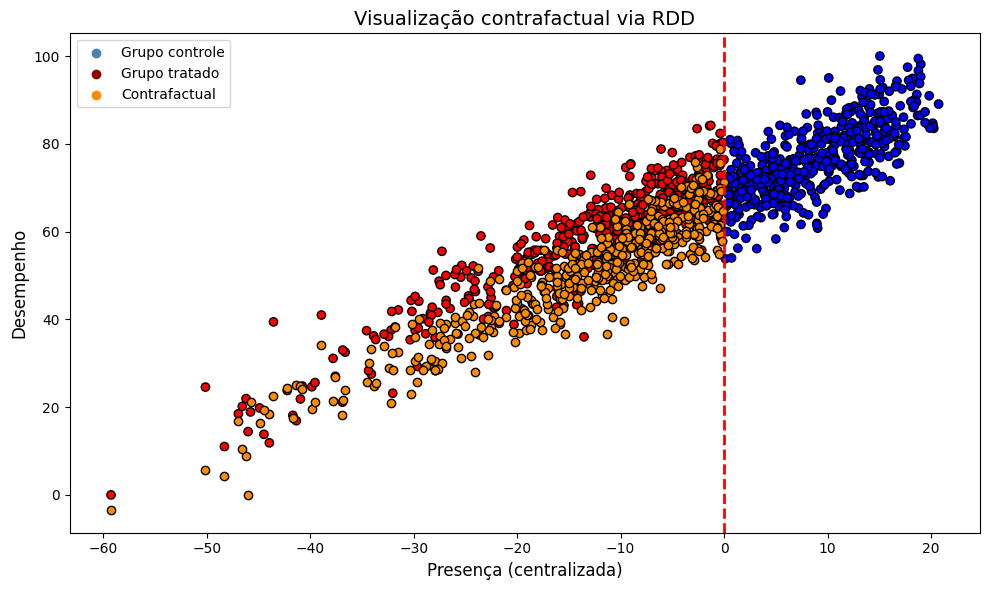

In [11]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

# Ajuste do modelo
reg = sm.OLS(data['Performance'], sm.add_constant(data[['Treatment', 'Attendance_c']]))
result = reg.fit()

# Gerar valores contrafactuais: grupo tratado com Treatment = 0
data2 = data.copy()
data2['Treatment'] = 0
data2['predfit2'] = result.predict(sm.add_constant(data2[['Treatment', 'Attendance_c']]))

# Adiciona ruído visual apenas ao lado tratado
data2.loc[data2['Attendance_c'] < 0, 'predfit2'] += np.random.normal(0, 5, size=(data2['Attendance_c'] < 0).sum())

# Plot dos valores observados
plt.figure(figsize=(10, 6))
plt.scatter(data['Attendance_c'], data['Performance'],
            c=data['Treatment'], cmap=plt.cm.bwr,
            marker='o', edgecolors='k')

# Linha de corte
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)

# Plot dos valores contrafactuais com ruído
plt.scatter(data2.loc[data2['Attendance_c'] < 0, 'Attendance_c'],
            data2.loc[data2['Attendance_c'] < 0, 'predfit2'],
            color='darkorange', marker='o', edgecolors='k')

# Legenda
plt.scatter([], [], c='steelblue', marker='o', label='Grupo controle')
plt.scatter([], [], c='darkred', marker='o', label='Grupo tratado')
plt.scatter([], [], c='darkorange', marker='o', label='Contrafactual')
plt.legend()

# Legendas dos eixos e título
plt.xlabel("Presença (centralizada)", fontsize=12)
plt.ylabel("Desempenho", fontsize=12)
plt.title("Visualização contrafactual via RDD", fontsize=14)

plt.tight_layout()
plt.show()